# Featuring
* Features: Pclass, Sex, ~~Ticket~~,~~Cabin~~, Embarked, IsAlone, Age, Fare


According to linear correlation matrix down below, seems only `Age` and `Survival`'s such relations are not significant

In [14]:
%pylab inline
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm, tree, neighbors, neural_network
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [15]:
# Read in our csv files downloaded from Kaggle
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
# Split the data into equal parts and check relevance to survival
train_data['AgeRange'] = pd.cut(train_data['Age'], 5)
train_data[['AgeRange','Survived']].groupby(['AgeRange'],as_index=False).mean().sort_values(by='AgeRange', ascending=True)

,AgeRange,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.369942
2,"(32.252, 48.168]",0.404255
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [17]:
# Cut, n=5, wasn't representativ of the data so use qcut, n=4
train_data['FareRange'] = pd.qcut(train_data['Fare'], 4)
train_data[['FareRange','Survived']].groupby(['FareRange'],as_index=False).mean().sort_values(by='FareRange', ascending=True)

,FareRange,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [18]:
# Drop columns used for illustration
train_data.drop(columns=['FareRange', 'AgeRange'], inplace=True)

In [19]:
train_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [20]:
full_data = [train_data, test_data]

map_embarked = dict(zip(train_data.Embarked.fillna(''), 
                        train_data.Embarked.fillna('').astype('category').cat.codes))

for dataset in full_data:
    # Create boolean 'IsAlone' to represent 'Sibsp' and 'Parch'
    dataset['IsAlone'] = 0
    dataset.loc[dataset['SibSp'] + dataset['Parch'] == 0, 'IsAlone'] = 1
    
    # Drop irrelevant/cumbersome columns and make 'PassengerId' the index
    dataset.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], inplace=True)
    dataset.set_index(keys=['PassengerId'], drop=True, inplace=True)

    # Create map and fill NaN values
    dataset_nan_map = {
        'Age': dataset['Age'].mean(),
        'Fare': dataset['Fare'].mean(),
    }
    dataset.fillna(value=dataset_nan_map, inplace=True)
    
    # map mixed types to numbers and fill nan values
    columns_map = {
        'Sex': {'male': 0, 'female': 1},
    }
    dataset.replace(columns_map, inplace=True)
    
    dataset['Embarked'] = dataset.Embarked.fillna('').map(map_embarked)
    
    # Change to ordinal values based on bands created above
    dataset['Age'] = dataset["Age"].apply(lambda x: 0 if x <= 16 
                                          else 1 if x > 16 and x <= 32
                                          else 2 if x > 32 and x <= 48
                                          else 3 if x > 48 and x <= 64
                                          else 4)
    dataset['Fare'] = dataset["Fare"].apply(lambda x: 0 if x <= 7.91 
                                            else 1 if x > 7.91 and x <= 14.454
                                            else 2 if x > 14.454 and x <= 31
                                            else 3)
    
# Split data
X = train_data.loc[:, train_data.columns != 'Survived']
y = train_data.loc[:, 'Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [21]:
train_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone
PassengerId,,,,,,,
1,0,3,0,1,0,3,0
2,1,1,1,2,3,1,0
3,1,3,1,1,1,3,1
4,1,1,1,2,3,3,0
5,0,3,0,2,1,3,1


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

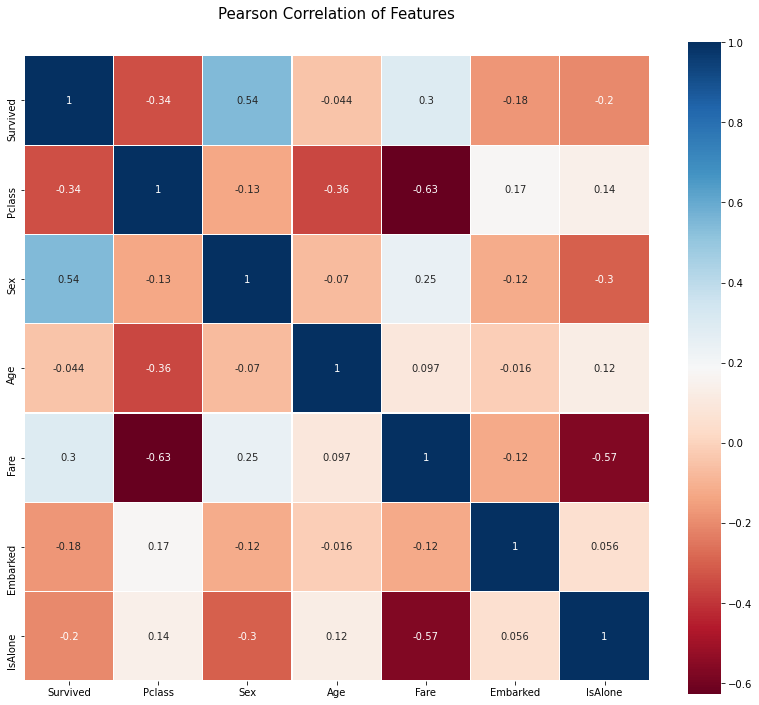

In [22]:
# Pearson Correlation Matrix
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [23]:
clf = neural_network.MLPClassifier(
                                    hidden_layer_sizes = (10, 10),
                                    activation = 'relu',
                                    solver = 'adam',
                                    batch_size = 32,
                                    learning_rate = 'constant',
                                    learning_rate_init = 0.0005,
                                    max_iter = 10000,
                                    random_state = 25,
                                    )

# scores = cross_val_score(NN_clf, X, y, cv=5)
# print(sum(scores)/len(scores), scores)

clf.fit(X_train.values, y_train.values)
print(clf.score(X_test.values, y_test.values))

# scores = cross_val_score(clf, X, y, cv=5)
# print(sum(scores)/len(scores), scores)

y_pred = clf.predict(X_test.values)
y_truth = y_test.values

0.8295964125560538


In [24]:
tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
print(f'fpr: {fp/(fp+tn)} fnr: {fn/(fn+tp)}')
print("Confusion Matrix")
print(confusion_matrix(y_truth, y_pred, labels=[0, 1]))
print("")
print("True Negatives", tn)
print("False Positives", fp)
print("False Negatives", fn)
print("True Positives", tp)
print(f'fpr: {fp/(fp+tn)} fnr: {fn/(fn+tp)}')

fpr: 0.07482993197278912 fnr: 0.35526315789473684
Confusion Matrix
[[136  11]
 [ 27  49]]

True Negatives 136
False Positives 11
False Negatives 27
True Positives 49
fpr: 0.07482993197278912 fnr: 0.35526315789473684


Confusion matrix, without normalization
[[136  11]
 [ 27  49]]


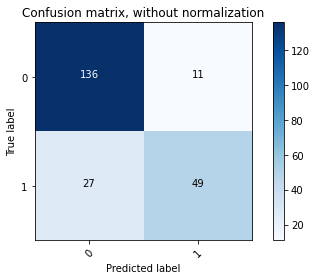

In [25]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_truth, y_pred)
class_names=['0', '1']
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [26]:
predictions = clf.predict(test_data.values)

In [27]:
type(predictions)

numpy.ndarray

In [28]:
pred_df = pd.DataFrame(predictions, index=test_data.index, columns=['Survived'])
type(pred_df)

pandas.core.frame.DataFrame

In [29]:
pred_df.to_csv('predictions.csv', header=True, sep=',')